In [1]:
#################################################
# Parameters
#################################################

In [2]:


dt = 0.001       # simulation time step  
t_rc = 0.02      # membrane RC time constant
t_ref = 0.002    # refractory period
t_pstc = 0.1     # post-synaptic time constant
N_A = 50         # number of neurons in first population
N_B = 40         # number of neurons in second population
N_samples = 100  # number of sample points to use when finding decoders
rate_A = 25,75  # range of maximum firing rates for population A
rate_B = 50,100 # range of maximum firing rates for population B

(50,100)

In [3]:
function input(t)
    return sin(t)
end

function func(x)
    return x.*x
end

function uniform(low, high)
    return low + rand() *(high - low)
end

uniform (generic function with 1 method)

In [4]:
#################################################
# Step 1: Initialization
#################################################

In [5]:
# create random encoders for the two populations
encoder_A = [float(rand([-1, 1])) for i=1:N_A] 
encoder_B = [float(rand([-1, 1])) for i=1:N_B];

In [6]:
function generate_gain_and_bias(count, intercept_low, intercept_high, rate_low, rate_high)
    gain = zeros(count)
    bias = zeros(count)
    for i = 1:count
         # desired intercept (x value for which the neuron starts firing
        intercept = uniform(intercept_low, intercept_high)
         # desired maximum rate (firing rate when x is maximum)
        rate = uniform(rate_low, rate_high)
        
        # this algorithm is specific to LIF neurons, but should
        #  generate gain and bias values to produce the desired
        #  intercept and rate
        z = 1.0 / (1.0 - exp((t_ref-(1.0/rate))/t_rc))
        gain[i] = (1.0 - z)/(intercept - 1.0)
        bias[i] = 1.0 - gain[i] * intercept
    end
    return gain,bias
end

# random gain and bias for the two populations
gain_A, bias_A = generate_gain_and_bias(N_A, -1, 1, rate_A[1], rate_A[2])
gain_B, bias_B = generate_gain_and_bias(N_B, -1, 1, rate_B[1], rate_B[2])            
        
        
        
    

([1.97492,34.1086,1.36152,0.576946,2.11879,0.78999,0.487278,1.23044,21.3283,0.961275  …  1.41765,1.47251,1.32615,1.08815,1.58367,0.960117,0.420133,0.952851,0.590157,0.896487],[0.572774,-32.2224,1.41533,1.19964,0.760639,1.03407,1.46135,1.78765,-18.6231,1.20027  …  1.42056,1.18461,1.38977,1.58992,0.65576,1.19685,1.32554,1.06809,1.45428,1.05943])

In [7]:
# a simple leaky integrate-and-fire model, scaled so that v=0 is resting 
#  voltage and v=1 is the firing threshold

# function run_neurons(input, v, ref)
#     dV = dt * (input - v)/t_rc # the LIF voltage change equation
#     v += dV 
#     v[find(v .< 0.0)] = 0.0  # don't allow voltage to go below 0
#     # if we are in our refractory period
#     #   keep voltage at zero and
#     #   decrease the refractory period
#     inref = find(ref .> 0.0)
#     v[inref] = 0.0
#     ref[inref] -= dt
#     # reset the voltage if we spiked (v > 1)
#     fired = find(v .> 1.0)
#     v[fired] = 0.0
#     #print(spikes)
#     spikes = falses(length(v))
#     spikes[fired] = true
#     return spikes
# end

function run_neurons(input, v, ref)
    n_neurons = length(v)
    spikes = falses(n_neurons)
    dV = zeros(v)
    
    for i = 1:n_neurons
        dV = dt* (input[i] - v[i])/ t_rc
        v[i] += dV
        if (v[i] < 0)
            v[i] = 0.0
        end
        
        if (ref[i] > 0.0)
            v[i] = 0.0
            ref[i] -= dt
        end
        
        if (v[i] > 1.0)
            spikes[i] = true
            v[i] = 0.0
            ref[i] = t_ref
        end
        
    end
    return spikes
end
        
        
    
    
    

run_neurons (generic function with 1 method)

In [8]:
# measure the spike rate of a whole population for a given represented value x 
function compute_response(x, encoder, gain, bias, time_limit=0.5)
    N = length(encoder) # number of neurons
    v = rand(N) # randomized voltages for each neuron in the ensemble
    ref = zeros(N) # ref voltage of each neuron
    
    # compute input corresponding to x
    input = ((x * encoder) .* gain) + bias    
    count = zeros(N)  #spike count for each neuron
    
     # feed the input into the population for a given amount of time
    t = 0.0
    while t < time_limit
        spikes = run_neurons(input, v, ref)
        count[spikes] += 1.0
        t += dt
    end
    
    count = count/time_limit
    return count # return the spike rate (in Hz)
end

   
    
    
    
   
    

compute_response (generic function with 2 methods)

In [9]:

# compute the tuning curves for a population 
function compute_tuning_curves(encoder, gain, bias)
    ##### x_values = [(2.0*i/N_samples) - 1.0 for i in range(0, N_samples)]
    ##### The above return an Array{Any} while the below return Array{Float64} !!!!!!!!!!!!
    
   
    x_values = zeros(N_samples)
    for i in range(0, N_samples)
        x_values[i+1] = (2.0 * float(i)/float(N_samples)) - 1.0
    end
    # build up a matrix of neural responses to each input (i.e. tuning curves)
    #The python reference version creates A'; but we create A here 
    
    num_neurons = length(encoder)
    A = zeros(num_neurons, N_samples)
         
    for i = 1:length(x_values)
        x = x_values[i]
        response = compute_response(x, encoder, gain, bias)
        A[:,i] = response       
    end
    
#     A = [] ## zeros(N_samples, num_neurons)    
#     for x in x_values
#         response = compute_response(x, encoder, gain, bias)
#         push!(A, response')
#     end
    return x_values, A 
end

compute_tuning_curves (generic function with 1 method)

In [10]:
# get the decoders
function compute_decoder(encoder, gain, bias, funct=(x->x))
    # get the tuning curves
    x_values, A = compute_tuning_curves(encoder, gain, bias)
    # get the desired decoded value for each sample point
    value = funct(x_values) #eval_function(funct, x_values) #funct(x_values) #
         
     # find the optimum linear decoder
    Gamma = A*A'
    Upsilon = A*value
    Ginv = inv(Gamma)
    decoder = (Ginv*Upsilon)/dt
    return decoder
end

     
    

compute_decoder (generic function with 2 methods)

In [11]:
# find the decoders for A and B
decoder_A = compute_decoder(encoder_A, gain_A, bias_A, func);
decoder_B = compute_decoder(encoder_B, gain_B, bias_B)

# compute the weight matrix
weights = decoder_A * encoder_B'  ;


In [12]:
#################################################
# Step 2: Running the simulation
#################################################

In [13]:
v_A = zeros(N_A)       # voltage for population A
ref_A = zeros(N_A)     # refractory period for population A
input_A = zeros(N_A)   # input for population A

v_B = zeros(N_B)       # voltage for population B     
ref_B = zeros(N_B)     # refractory period for population B
input_B = zeros(N_B)   # input for population B

# scaling factor for the post-synaptic filter
pstc_scale = 1.0 - exp(-dt/t_pstc)  


# for storing simulation data to plot afterward
inputs = zeros(0)            
times = zeros(0)
outputs = zeros(0)
ideal = zeros(0)

output = 0.0            # the decoded output value from population B
t = 0.0 

input_A = zeros(N_A)
input_B = zeros(N_B) ; 

tic()
while t < 10.0
    # call the input function to determine the input value
    x = input(t)
    # convert the input value into an input for each neuron
    input_A = ((x * encoder_A) .* gain_A) + bias_A
     # run population A and determine which neurons spike
    spikes_A = run_neurons(input_A, v_A, ref_A)
    
    # decay all of the inputs (implementing the post-synaptic filter)
    input_B *= (1.0 - pstc_scale)
    
    # for each neuron that spikes, increase the input current
    #  of all the neurons it is connected to by the synaptic
    #  connection weight
    for i = 1:length(spikes_A)
        if(spikes_A[i])
            for j = 1:N_B
                input_B[j] += weights[i,j] * pstc_scale
            end
        end
    end

    # compute the total input into each neuron in population B
    #  (taking into account gain and bias)    
    total_B = zeros(N_B)
    total_B = gain_B .* input_B .+ bias_B
    
     # run population B and determine which neurons spike
    spikes_B=run_neurons(total_B, v_B, ref_B)
    
     # for each neuron in B that spikes, update our decoded value
    #  (also applying the same post-synaptic filter)
    output *= (1.0-pstc_scale)
    for j = 1:length(spikes_B)
        if(spikes_B[j])
            output += decoder_B[j]*pstc_scale
        end
    end
    
    #print(t, output)
    push!(times, t)
    push!(inputs, x)
    push!(outputs,output)
    push!(ideal,func(x))
    
    t += dt;   

end

toc()
    
    
    
    
    
    
    
    
    
    
    
    

elapsed time: 0.

0.692118274

692118274 seconds


In [14]:
#################################################
# Step 3: Plot the results
#################################################

In [15]:
x,A = compute_tuning_curves(encoder_A, gain_A, bias_A)
x,B = compute_tuning_curves(encoder_B, gain_B, bias_B);


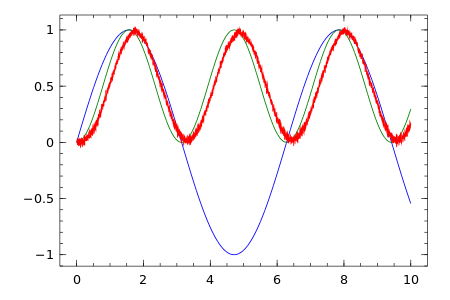

In [19]:
using Winston;
plot(times, inputs, "b")
hold(true)
plot(times, ideal, "g")
plot(times, outputs, "r")

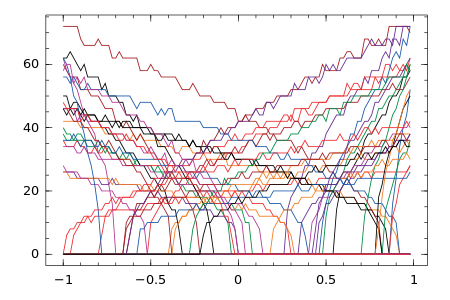

In [17]:
hold(false)
Winston.plot(x,A)

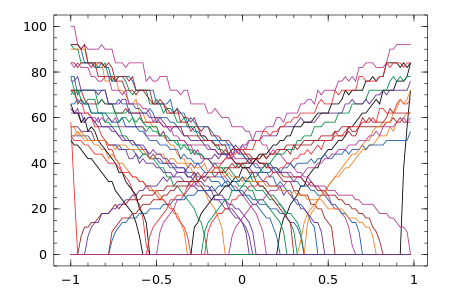

In [18]:
Winston.plot(x,B)